In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_gaussian_quantiles

### SVM vs. RF on Gaussian

In [4]:
# Generate dataset with Gaussian quantiles 
x, y = make_gaussian_quantiles(
    n_samples = 1000,
    n_features = 2, 
    n_classes = 2, 
    cov = 3.0, # put some noise into the data to prevent overfitting
    random_state = 808
)

# Introduce additional noise by flipping some labels (0s,1s)
flip_mask =  np.random.rand(len(y)) < 0.15 # boolean mask, shuffle 15% of labels to introduce more noise
y[flip_mask] = 1 - y[flip_mask] # for those 15%, flip 0 to 1 and 1 to 0

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 808)

In [14]:
# Set up SVM with RBF kernel and hyperparameter tuning and fit
param_grid_svm = {"C": np.logspace(-2,2,10)}
grid_search_svm = GridSearchCV(SVC(kernel = "rbf", random_state = 808), 
                               param_grid_svm, cv = 5)

# fit
grid_search_svm.fit(x_train, y_train)

# Best SVM model
best_svm = grid_search_svm.best_estimator_
y_train_pred_svm = best_svm.predict(x_train)
y_test_pred_svm = best_svm.predict(x_test)


In [15]:
# Train a Random Forest model with hyperparameter tuning and fit
param_grid_rf = {"n_estimators": [10, 50, 100, 2000], 
                 "max_depth": [2,5,10,None]
                }
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = 808), 
                              param_grid_rf, 
                              cv = 5)
grid_search_rf.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=808),
             param_grid={'max_depth': [2, 5, 10, None],
                         'n_estimators': [10, 50, 100, 2000]})

In [16]:
# Best RF model
best_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf.predict(x_train)
y_test_pred_rf = best_rf.predict(x_test)

In [20]:
# Compute accuracy for both models
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"SVM Train Accuracy: {train_acc_svm:.2f}, Test Accuracy: {test_acc_svm:.2f}")
print(f"RF Train Accuracy: {train_acc_rf:.2f}, Test Accuracy: {test_acc_rf:.2f}")


SVM Train Accuracy: 0.85, Test Accuracy: 0.82
RF Train Accuracy: 0.85, Test Accuracy: 0.79


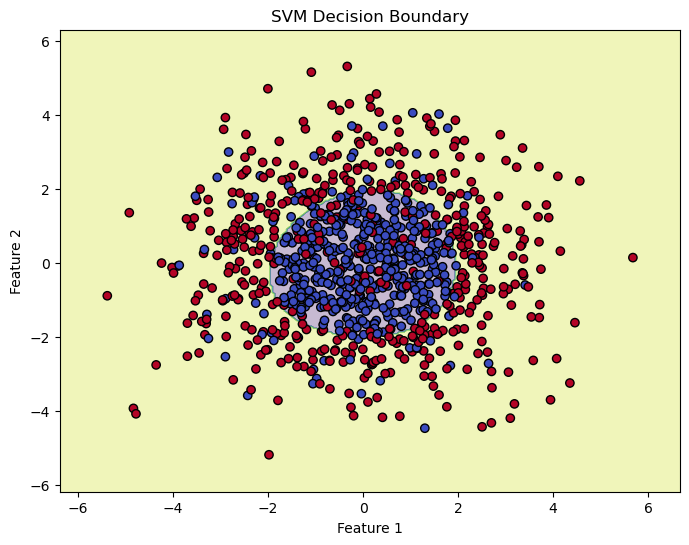

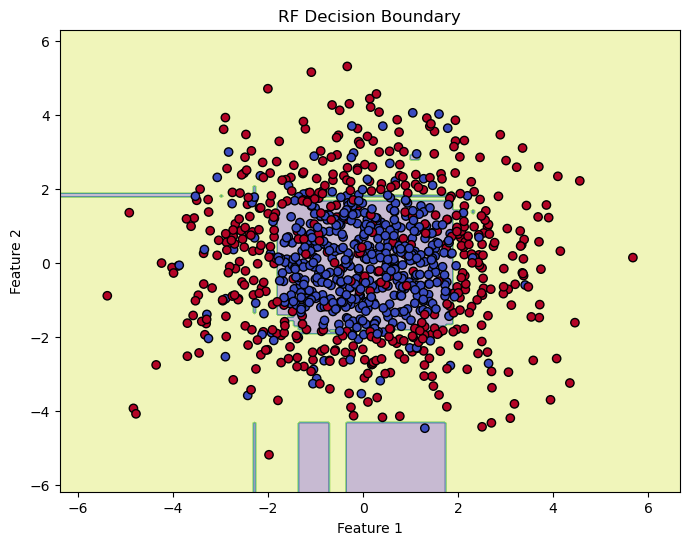

In [21]:
# Function to visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    h = 0.05  # Step size in the mesh
    
    # Define the range for plotting based on feature values
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Reshape predictions to match the grid shape for contour plotting
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

# Visualize decision boundaries
plot_decision_boundary(best_svm, x, y, "SVM Decision Boundary")
plot_decision_boundary(best_rf, x, y, "RF Decision Boundary")

### Effect of C parameter on overfitting

In [22]:
# Test different values of C in SVM with an RBF kernel
C_values = np.logspace(-3,3,10)
train_scores_svm = []
test_scores_svm = []

# Fit a series of SVM, varying C
for C in C_values:
    svm = (SVC(
        kernel = "rbf", 
        C = C, 
        random_state = 808
    )
           .fit(x_train, y_train)
          )
    
    
    # Compute train and test accuracy
    train_scores_svm.append(accuracy_score(y_train, svm.predict(x_train)))
    test_scores_svm.append(accuracy_score(y_test, svm.predict(x_test)))

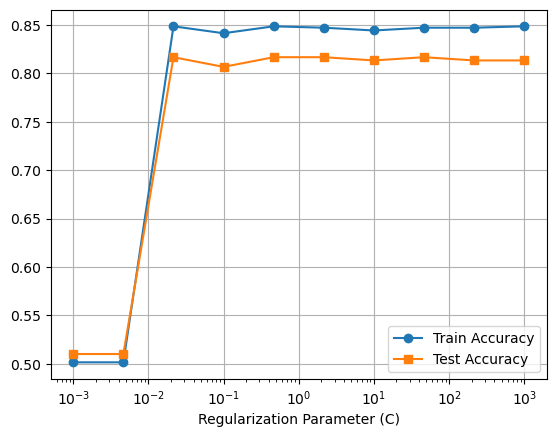

In [37]:
# Plot Learning Curve: Training vs. Test Accuracy
plt.plot(C_values, train_scores_svm, marker = "o", label = "Train Accuracy")
plt.plot(C_values, test_scores_svm, marker = "s", label = "Test Accuracy")
plt.xscale("log")
plt.xlabel("Regularization Parameter (C)")
plt.legend()
plt.grid(True)
plt.show()